In [1]:
import os.path
import sys

import os

# Récupère le chemin d'accès parent de sys.path[0]
parent_dir = os.path.dirname(sys.path[0])

sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa

## L'implimentation d'un systeme multi agent qui suit le Protocole Ennemie

## Création des Agents

In [2]:
class Recuit_sem(mesa.Agent):
    
    # Création d'agent Recuit simulé 


    def __init__(self, model,parameters,pool_key):
        
        super().__init__(self,model)
        self.parameters = parameters
        self.pool_key = pool_key # le pool qui va etre amélioré par l'algorithme
        

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Recuit simulé
        solution_index = np.random.randint(len(self.model.Pool[self.pool_key]))
        new_solution, meilleure_valeur , _  = recuit_simule(self.model.Pool[self.pool_key][solution_index],self.parameters['temperature_initiale'] , self.parameters['temperature_finale'],alpha=0.99)
        self.model.Pool[self.pool_key][solution_index] = new_solution
        
            
    def step(self):
        
        self.execute()

In [3]:
class Tabou(mesa.Agent):
    
    # Création d'agent Tabou 

    def __init__(self,  model,parameters,pool_key):
        super().__init__(self,model)
      
        self.parameters = parameters
        self.pool_key = pool_key # le pool qui va etre amélioré par l'algorithme

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Tabou
        solution_index = np.random.randint(len(self.model.Pool[self.pool_key]))
        new_solution, meilleure_valeur , _ = tabou(self.model.Pool[self.pool_key][solution_index] ,self.parameters['taille_tabou'],self.parameters['max_iterations'],self.parameters['n_voisin'])
        self.model.Pool[self.pool_key][solution_index] = new_solution

            
    def step(self):
        self.execute()

In [4]:
class Genetic(mesa.Agent):
    
    # Création d'agent genetique 

    def __init__(self,  model,parameters,pool_key):

        super().__init__(self,model)
        self.parameters = parameters
        self.pool_key = pool_key

    def execute(self):

        # Prendre le Pool comme une population initial et la remplacer par une population améliorer par l'algo genetique
        new_solution, meilleure_valeur , _ ,population = genetique(self.model.Pool[self.pool_key],self.parameters['taux_mutation'],self.parameters['max_iterations'])
        self.model.Pool[self.pool_key] = copy.deepcopy(population)
        
            
    def step(self):
        self.execute()

In [7]:
def compute_Pool_avg(model):

    # Calculer le cout moyenne des solutions dans le Pool
    couts = [cout(model.Pool[i]) for i in range(len(model.Pool))]
    
    return sum(couts)/len(couts)

def compute_Pool_min(model):
    
    # Calculer le cout minimum des solution dans le Pool
    couts = [cout(model.Pool[i]) for i in range(len(model.Pool))]

    return min(couts)

def get_the_best_solution(model,key_pool):

    # Récupérer la meilleur solution dans le Pool
    couts = np.array([cout(model.Pool[key_pool][i]) for i in range(len(model.Pool[key_pool]))])

    return model.Pool[key_pool][np.argmin(couts)]

In [6]:
def compute_cout_pool1(model):
    
    # Calculer le cout moyenne des solutions dans le Pool
    couts = [cout(model.Pool['pool1'][i]) for i in range(len(model.Pool['pool1']))]

    return min(couts)


def compute_cout_pool2(model):
    
    # Calculer le cout moyenne des solutions dans le Pool
    couts = [cout(model.Pool['pool2'][i]) for i in range(len(model.Pool['pool2']))]

    return min(couts)

In [8]:
def compute_1(model):
    
    # Calculer le cout moyenne des solutions dans le Pool
    return model.resultats['equipe1']


def compute_2(model):
    
    # Calculer le cout moyenne des solutions dans le Pool

    return model.resultats['equipe2']

In [9]:
## Les paramètres des Algorithmes 
num_clients = 100
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-7 } , 'tabou' : {'taille_tabou' : nombre_client , 'max_iterations' : 100 , 'n_voisin' : 10} , 'genetic'  : {'taux_mutation' : 0.1 ,'max_iterations' : 100 }}

In [10]:
class SMA_ENNEMIE(mesa.Model):
    
    """Création d'environnement de communication entre les agents"""


    def __init__(self,Pool,parameters):
        
        self.schedule1 = mesa.time.RandomActivation(self)
        self.schedule2 = mesa.time.RandomActivation(self)
        self.Pool = Pool
        self.parametres = parameters
        self.resultats = {}

        # Instanciation des agents 
        self.optimazers = {'equipe1' : [Recuit_sem(self,self.parametres['rs'],'pool1'), Genetic(self,self.parametres['genetic'],'pool1'),Tabou(self,self.parametres['tabou'],'pool1')], 'equipe2' : [Tabou(self,self.parametres['tabou'],'pool2'), Genetic(self,self.parametres['genetic'],'pool2'),Recuit_sem(self,self.parametres['rs'],'pool2')] }
        self.schedule1.add(self.optimazers['equipe1'][0])
        #self.schedule1.add(self.optimazers['equipe1'][2])
        self.schedule2.add(self.optimazers['equipe2'][0])
        #self.schedule2.add(self.optimazers['equipe2'][2])

        ## Récuperer à chaque step la meilleur solution dans le Pool et son cout
        self.datacollector = mesa.DataCollector(
            model_reporters={"pool_1": compute_cout_pool1 , "pool_2": compute_cout_pool2 } )
        
        
        
        

    def step1(self):
        
        self.schedule1.step()
        self.resultats['equipe1'] = compute_cout_pool1(self)
        self.datacollector.collect(self)

    def step2(self):
        
        self.schedule2.step()
        self.resultats['equipe2'] = compute_cout_pool2(self)
        self.datacollector.collect(self)


In [11]:
## Création du Pool
POOL = {}
Pool = []
list_client_initial = [i for i in range(num_clients)]
for j in range(6): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(get_route_version2(x,time_window,Q))
    POOL['pool1'] = Pool
    
Pool = []
for j in range(6): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(get_route_version2(x,time_window,Q))
    POOL['pool2'] = Pool

In [16]:
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-7 } , 'tabou' : {'taille_tabou' : 20 , 'max_iterations' : 100 , 'n_voisin' : 10} , 'genetic'  : {'taux_mutation' : 0.1 ,'max_iterations' : 100 }}
sma_env = SMA_ENNEMIE(POOL,parameters)
T0 = 1
N0 = 10

### Exécution du Système multu agent ennemie & Résultats

In [13]:
# initiation

sma_env = SMA_ENNEMIE(POOL,parameters)

for i in range(1) : 

    sma_env.step1()
    sma_env.step2()

    if i%10 == 0 :

        sma_env.optimazers['equipe1'][1].execute()
        sma_env.optimazers['equipe2'][1].execute()
    

cout_equipe1 = sma_env.resultats['equipe1']
cout_equipe2 = sma_env.resultats['equipe2']

In [17]:
cout_equipe1 = compute_cout_pool1(sma_env)
cout_equipe2 = compute_cout_pool2(sma_env)

In [18]:
cout_equipe1 , cout_equipe2 

(3309.8162228426177, 3195.92829542385)

In [19]:
sma_env.optimazers['equipe1'][0].parameters

{'temperature_initiale': 1, 'temperature_finale': 1e-07}

In [20]:
for i in range(500):

    if cout_equipe1 < cout_equipe2 : 
            print('switch2')
            sma_env.parametres['tabou']['n_voisin'] = N0*(int(cout_equipe2/cout_equipe1)+1)
            for k in range(100) :
                
                sma_env.step2()
                sma_env.datacollector.collect(sma_env)
                
                if k%10 == 0 :
                    sma_env.optimazers['equipe2'][1].execute()
                    sma_env.datacollector.collect(sma_env)
                    
                cout_equipe2 = sma_env.resultats['equipe2']

                if cout_equipe1>cout_equipe2 : 
                    break


    if cout_equipe1 >=cout_equipe2 : 
            
            print('switch1')
            sma_env.parametres["rs"]['temperature_initiale'] = (cout_equipe1/cout_equipe2)*T0
            
            for k in range(100) :
                
                sma_env.step1()
                sma_env.datacollector.collect(sma_env)
                
                if k%10 == 0 :
                    sma_env.optimazers['equipe1'][1].execute()
                    sma_env.datacollector.collect(sma_env)
                    
                cout_equipe1 = sma_env.resultats['equipe1']

                if cout_equipe1<cout_equipe2 : 
                    break


    

            

switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch1
switch2
switch1
switch2
switch1
switch1
switch2
switch1
switch2
switch1
switch2
switch1
switch1
switch1
switch1


KeyboardInterrupt: 

In [21]:
def get_solution_from_sma(sma_env):

    if sma_env.resultats['equipe1'] > sma_env.resultats['equipe2'] : 

         return get_the_best_solution(sma_env,'pool2')

    return get_the_best_solution(sma_env,'pool1')

<AxesSubplot: title={'center': 'Résultats protocole Ennemie'}>

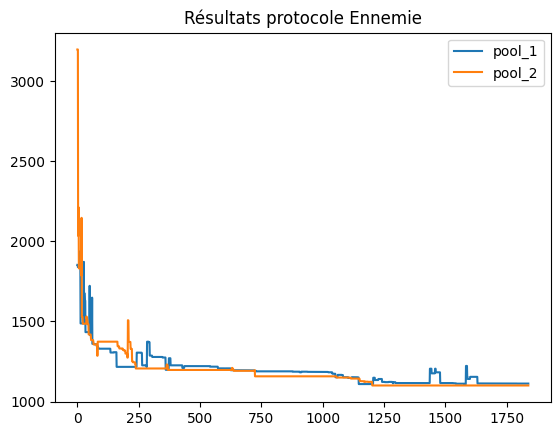

In [22]:
sma_env.datacollector.get_model_vars_dataframe().plot(title='Résultats protocole Ennemie')
#plt.savefig('Protocole_ennemie')

In [25]:
print('The best solution is :' ,get_solution_from_sma(sma_env))
print('With the cost :' , cout(get_solution_from_sma(sma_env)))
print('The number of vehicle :' ,len(get_solution_from_sma(sma_env)))

The best solution is : [[38, 32, 15, 57, 44, 70, 37, 77, 28, 68, 76, 48, 13, 87, 2, 49, 71, 74, 79, 34, 88, 55, 3, 42, 80, 62, 8, 92, 20], [16, 98, 67, 73, 45, 1, 9, 72, 5, 47, 83, 31, 50, 64, 59, 21, 43, 78, 40, 22, 12, 17], [61, 58, 53, 27, 0, 46, 39, 82, 86, 25, 60, 6, 90, 89, 14, 99, 24, 52, 93, 96, 56, 30, 94, 85, 26, 63, 75, 4, 29, 65, 69, 36, 18], [23, 84, 54, 97, 51, 91, 95, 66, 7, 35, 81, 19, 10, 11, 33, 41]]
With the cost : 1101.0127734913403
The number of vehicle : 4


In [26]:
print('The best solution is :' ,get_solution_from_sma(sma_env))
print('With the cost :' , cout(get_solution_from_sma(sma_env)))
print('The number of vehicle :' ,len(get_solution_from_sma(sma_env)))

The best solution is : [[38, 32, 15, 57, 44, 70, 37, 77, 28, 68, 76, 48, 13, 87, 2, 49, 71, 74, 79, 34, 88, 55, 3, 42, 80, 62, 8, 92, 20], [16, 98, 67, 73, 45, 1, 9, 72, 5, 47, 83, 31, 50, 64, 59, 21, 43, 78, 40, 22, 12, 17], [61, 58, 53, 27, 0, 46, 39, 82, 86, 25, 60, 6, 90, 89, 14, 99, 24, 52, 93, 96, 56, 30, 94, 85, 26, 63, 75, 4, 29, 65, 69, 36, 18], [23, 84, 54, 97, 51, 91, 95, 66, 7, 35, 81, 19, 10, 11, 33, 41]]
With the cost : 1101.0127734913403
The number of vehicle : 4


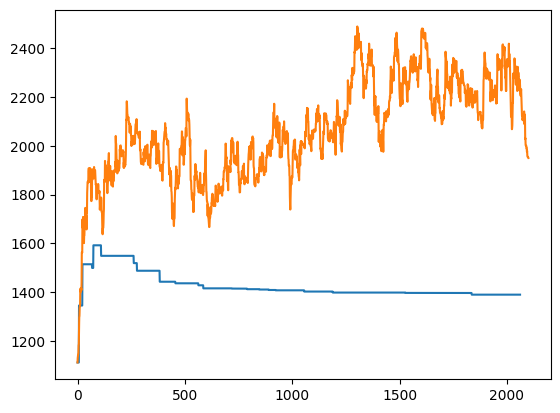

In [27]:
taille_tabou = 2
max_iterations = 2100
taille_voisin = 10
list_client_initial = POOL["pool1"][0]

meilleure_solution, meilleure_valeur , history_1 = tabou(list_client_initial, taille_tabou, max_iterations,10)
best_state, best_energy , history_t_1 = recuit_simule(list_client_initial,  temperature_initiale=1.0, temperature_finale=1e-9, alpha=0.99)
 

plt.plot(history_t_1, label = 'temperature_initiale=1.0')

 
plt.plot(history_1,label = 'taille_voisins = 10')
 
 

In [269]:
import folium

def tracer_segments_folium(L,color,m):
    # Créer une carte centrée sur le premier point de la liste

    # Ajouter des marqueurs pour chaque point de la liste
    for c in L:

        folium.Marker(location=c).add_to(m)

    # Ajouter une Polyline reliant les marqueurs
    folium.PolyLine(locations=L, color=color).add_to(m)

    # Afficher la carte
    


In [270]:
data_client_index

,Unnamed: 0,CUSTOMER_LATITUDE,CUSTOMER_LONGITUDE,CUSTOMER_TIME_WINDOW_FROM_MIN,CUSTOMER_TIME_WINDOW_TO_MIN,CUSTOMER_DELIVERY_SERVICE_TIME_MIN,TOTAL_WEIGHT_KG,a,b,d
0,1,44.056710,17.449280,481.0,961.0,8.05,3.372000,481.0,961.0,8.05
1,2,43.111171,17.699285,481.0,961.0,21.57,172.633000,481.0,961.0,21.57
2,3,44.055470,17.451640,481.0,961.0,10.60,44.662000,481.0,961.0,10.60
3,4,44.055287,17.449447,480.0,840.0,14.79,62.259000,480.0,840.0,14.79
4,5,43.187700,17.543780,480.0,840.0,35.00,179.824000,480.0,840.0,35.00
...,...,...,...,...,...,...,...,...,...,...
568,569,44.073827,17.448408,481.0,961.0,14.00,56.385000,481.0,961.0,14.00
569,570,43.191631,17.677887,481.0,961.0,12.44,13.192389,481.0,961.0,12.44
570,571,43.542270,17.404194,481.0,961.0,8.87,5.332026,481.0,961.0,8.87
571,572,43.355200,17.813670,480.0,900.0,9.35,36.879000,480.0,900.0,9.35


In [271]:
def plot_solution(solution):

    m = folium.Map(location=(0,0), zoom_start=12)
    K = len(solution)
    k = 0
    color = ['red' , 'blue' , 'green']
    for vehicule in solution : 

        L = [(data_client_index['CUSTOMER_LATITUDE'].iloc[k] , data_client_index['CUSTOMER_LONGITUDE'].iloc[k]) for k in range(len(vehicule))]
        tracer_segments_folium(L,color[k],m)
        k = k + 1
    m.save('solution_ploted.html')


In [272]:
plot_solution(get_route_version2(get_solution_from_sma(sma_env),time_window,Q))

In [255]:
get_route_version2(get_solution_from_sma(sma_env),time_window,Q)

[[5, 0, 4, 3, 8, 9, 1, 6, 2, 7]]